In [1]:
import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.parsing.preprocessing import STOPWORDS
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from gensim.models.ldamulticore import LdaMulticore

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Securitizing rhetoric/language as that which invokes fear of
#  and/or promotes action to be taken against another who is 
#  framed to be acting either irrationally or against the 
#  interests of the state -- Me

# Split State of Union speeches at periods, grade each sentence 
#  using the model (itself based on set of base docs), aggregate
#  the scores of the speech's sentences to get an average score 
#  of securitization of the speech being analyzed. Observe how 
#  scores rise and fall with presidential terms, popularity, etc. 

# Start with most extreme language samples then move into the grey. 

# Securitization poorly describes docs at low-end of that spectrum.
#  Consider instead adopting notion of 'sovereignty' as guiding 
#  language when determining placement of docs in lower-half of 
#  the spectrum (0-2). Other words: 'national', 'domestic' (2);
#  'mutual', 'international' (0-1)

# Exclusive vs. Inclusive language

In [2]:
# Gather text for training

docs0 = ["""Share a peaceful future based on common values.
Conscious of its spiritual and moral heritage, the Union is founded on the indivisible,
universal values of human dignity, freedom, equality and solidarity; 
it is based on the principles of democracy and the rule of law.""", 
              """It seeks to promote balanced and sustainable development and ensures 
free movement of persons, services, goods and capital, and the freedom of establishment.""",
              """Enjoyment of these rights entails responsibilities and duties with regard
to other persons, to the human community and to future generations.""",
              """Open covenants of peace, openly arrived at, after which there shall be no private 
international understandings of any kind but diplomacy shall proceed always frankly and in 
the public view. Absolute freedom of navigation upon the seas, outside territorial waters, 
alike in peace and in war, except as the seas may be closed in whole or in part by 
international action for the enforcement of international covenants. The removal, so far as 
possible, of all economic barriers and the establishment of an equality of trade conditions 
among all the nations consenting to the peace and associating themselves for its maintenance.""",
              """Without this healing act the whole structure and validity of 
international law is forever impaired.""",
              """The Dardanelles should be permanently opened 
as a free passage to the ships and commerce of all nations under international guarantees."""]

docs1 = ["""It places the individual at the heart of its activities, by establishing the 
citizenship of the Union and by creating an area of freedom, security and justice.""",
"""A general association of nations must be formed under specific covenants 
for the purpose of affording mutual guarantees of political independence and territorial integrity 
to great and small states alike.""",
"""To this end, it is necessary to strengthen the protection of fundamental rights in
the light of changes in society, social progress and scientific and technological 
developments by making those rights more visible in a Charter. This Charter reaffirms,
with due regard for the powers and tasks of the Union and for the principle of subsidiarity, 
the rights as they result, in particular, from the constitutional traditions and international
obligations common to the Member States, the European Convention for the Protection of 
Human Rights and Fundamental Freedoms, the Social Charters adopted by the Union and by 
the Council of Europe and the case-law of the Court of Justice of the European Union and 
of the European Court of Human Rights.""",
"""develop friendly relations among nations based on respect for the principle of equal
rights and self-determination of peoples, and to take other appropriate 
measures to strengthen universal peace""",
"""A country should not discriminate between its trading partners and it should not
discriminate between its own and foreign products, services or nationals.""",
"""South Viet-Nam will pursue a  foreign policy of peace and independence. It will 
be prepared to establish relations with all countries irrespective of their political 
and social systems on the basis of mutual respect for independence and sovereignty and 
accept economic and technical aid from any country with no political conditions attached. """]

docs2 = ["""The Union contributes to the preservation and to the development of these common values 
while respecting the diversity of the cultures and traditions of the peoples of Europe 
as well as the national identities of the Member States and the organisation of their 
public authorities at national, regional and local levels""",
              """In this context the Charter will be interpreted by the 
courts of the Union and the Member States with due regard to the explanations prepared under 
the authority of the Praesidium of the Convention which drafted the Charter and updated under the
responsibility of the Praesidium of the European Convention.""",
              """Adequate guarantees given and taken that national armaments will be reduced to the lowest 
point consistent with domestic safety.""",
              """A free, open-minded, and absolutely impartial adjustment 
of all colonial claims, based upon a strict observance of the principle that in determining all 
such questions of sovereignty the interests of the populations concerned must have equal weight 
with the equitable government whose title is to be determined. The evacuation of all Russian 
territory and such a settlement of all questions affecting Russia as will secure the best and 
freest cooperation of the other nations of the world in obtaining for her an unhampered and 
unembarrassed opportunity for the independent determination of her own political development 
and national policy and assure her of a sincere welcome into the society of free nations under 
institutions of her own choosing; and, more than a welcome, assistance also of every kind that 
she may need and may herself desire.""", 
               """The treatment accorded Russia by her sister nations in the 
months to come will be the acid test of their good will, of their comprehension of her needs as
distinguished from their own interests, and of their intelligent and unselfish sympathy.
Belgium, the whole world will agree, must be evacuated and restored, without any attempt to limit 
the sovereignty which she enjoys in common with all other free nations.""",
               """No other single act will 
serve as this will serve to restore confidence among the nations in the laws which they have 
themselves set and determined for the government of their relations with one another.""",
              """All French territory should be freed and the invaded portions restored, and the wrong done to 
France by Prussia in 1871 in the matter of Alsace-Lorraine, which has unsettled the peace of the 
world for nearly fifty years, should be righted, in order that peace may once more be made secure 
in the interest of all.""",
              """A readjustment of the frontiers of Italy should be effected along clearly 
recognizable lines of nationality. The people of Austria-Hungary, whose place among the nations we 
wish to see safeguarded and assured, should be accorded the freest opportunity to autonomous 
development.""",
              """Romania, Serbia, and Montenegro should be evacuated; occupied territories restored; 
Serbia accorded free and secure access to the sea; and the relations of the several Balkan states 
to one another determined by friendly counsel along historically established lines of allegiance 
and nationality; and international guarantees of the political and economic independence and 
territorial integrity of the several Balkan states should be entered into.""",
              """The Turkish portion of the present Ottoman Empire should be assured a secure sovereignty,
but the other nationalities  which are now under Turkish rule should be assured an undoubted security
of life and an absolutely unmolested opportunity of autonomous development""",
              """An independent Polish state should be erected which should include the territories inhabited by 
indisputably Polish populations, which should be assured a free and secure access to the sea,
and whose political and economic independence and territorial integrity should be guaranteed by 
international covenant.""",
        """The United States and all other countries respect the independence, sovereignty, unity, and
        territorial integrity of Viet-Nam as recognized by the 1954 Geneva Agreements on Viet-Nam.""",
        """The parties agree on the convening of an International Conference within thirty days of the 
signing of this Agreement to acknowledge the signed agreements; to guarantee the ending of the war,
the maintenance of peace in Viet- Nam, the respect of the Vietnamese people's fundamental national rights,
and the South Vietnamese people's right to self-determination; and to contribute to and
guarantee peace in Indochina."""]

docs3 = ["""Blackshirts of revolution, men and women of all Italy, Italians all over the world,
beyond the mountains, beyond the seas, listen. A solemn hour is about to strike in the history
of the country. Twenty million Italians are at this moment gathered in the squares of all Italy. 
It is the greatest demonstration that human history records. Twenty million, one heart alone,
one will alone,one decision. This manifestation signifies that the tie between Italy and fascism
is perfect, absolute, unalterable.""",
              """But after the common victory, which cost Italy six hundred thousand dead, four hundred thousand lost,
one million wounded, when peace was being discussed around the table only the crumbs of a rich
colonial booty were left for us to pick up.""",
              """A people worthy of their past and their name cannot and never will 
take a different stand.""",
              """However we can never consider what we have achieved to be sufficient, because 
we must, and are determined to accomplish even more and greater tasks. We shall raise our country to 
the level of the most prosperous and civilized nations of the world. We shall endow our nation with
the broadest means and sources of welfare. We shall raise our national culture above the contemporary 
level of civilization. Therefore, we should judge the measure of time not according to the lax
mentality of past centuries, but in terms of the concepts of speed and movement of our century.""",
              """I have no doubt that we shall succeed in this, because the Turkish nation is of excellent character.
The Turkish nation is intelligent, because the Turkish nation is capable of overcoming difficulties 
of national unity, and because it holds the torch of positive sciences. I must make it clear with 
due emphasis, that a historical quality of the Turkish nation, which is an exalted human community, 
is its love for fine arts and progress in them.""",
              """This is why our national ideal is to constantly
foster and promote, with all means and measures, our nation’s excellent character, its tireless 
industriousness, intelligence, devotion to science, love for fine arts and sense of national unity."""]

docs4 = ["""Only brains softened by puerile illusions, by sheer ignorance,
can think differently, because they do not know what exactly is the Fascist Italy of 1935.
For many months the wheel of destiny and of the impulse of our calm determination moves toward
the goal.""",
              """In these last hours the rhythm has increased and nothing can stop it now.
It is not only an army marching towards its goal, but it is forty-four million Italians marching
in unity behind this army. Because the blackest of injustices is being attempted against them, 
that of taking from them their place in the sun. When in 1915 Italy threw in her fate with that 
of the Allies, how many cries of admiration, how many promises were heard?""",
              """Nevertheless, we cannot afford to overlook the possible developments of tomorrow.
To economic sanctions, we shall answer with our discipline, our spirit of sacrifice, our obedience. 
To military sanctions, we shall answer with military measures. To acts of war, 
we shall answer with acts of war. # talk of militarization and war""",
              """Let me repeat, in the most categorical manner, that the sacred pledge which
I make at this moment, before all the Italians gathered together today, is that I shall do everything 
in my power to prevent a colonial conflict from taking on the aspect and weight of a European war.
This conflict may be attractive to certain minds which hope to avenge their disintegrated temples 
through this new catastrophe.""",
              """The Turkish Nation! We are in the fifteenth year of the start of our war of liberation.
This is the greatest day marking the tenth year of our Republic. May it be celebrated.
At this moment as a member of the great Turkish nation, I feel the deepest joy and excitement 
for having achieved this happy day. My citizens, We have accomplished many and great tasks in 
a short time.""",
              """The greatest of these is the Turkish Republic, the basis of which is the Turkish heroism
and the great Turkish culture. We owe this success to the cooperative progress of the Turkish nation 
and its valuable army.""",
              """This ideal, which very well suits the Turkish nation, will enable it to succeed in performing the 
civilized task falling on it in securing true peace for all mankind. The Great Turkish Nation!""",
              """Today, I repeat with the same faith and determination that it will soon
be acknowledged once again by the entire civilized world that the Turkish nation, who has been 
progressing towards the national ideal in exact unison, is a great nation. Never have doubted that
the great, but forgotten, civilized characteristic and the great civilized talents of the Turkish 
nation, will, in its progress henceforth, rise like a new sun from the high horizon of civilization
for the future. The Turkish nation, I express my heartfelt wish that you will celebrate, 
after each decade elapsing into eternity, this great national day, in greater honor, happiness, 
peace and prosperity. How happy it is to say that I am a Turk!"""]

docs5 = ["""It is enough now. The League of Nations, instead of recognizing the 
rights of Italy, dares talk of sanctions, but until there is proof of the contrary, I refuse to 
believe that the authentic people of France will join in supporting sanctions against Italy.""", 
"""Six hundred thousand dead whose devotion was so heroic that the enemy commander justly admired 
them—those fallen would now turn in their graves. And until there is proof to the contrary,
I refuse to believe that the authentic people of Britain will want to spill blood and send Europe
into a catastrophe for the sake of a barbarian country, unworthy of ranking among civilized nations.""",
              """Never, as at this historical hour, have the people of Italy revealed 
such force of character, and it is against this people to which mankind owes its greatest conquest,
this people of heroes, of poets and saints, of navigators, of colonizers, that the world dares
threaten sanctions.""",
               """Italy! Italy! entirely and universally Fascist! The Italy of the blackshirt
fascist revolution, rise to your feet; let the cry of your determination rise to the skies and reach
our soldiers in East Africa. Let it be a comfort to those who are about to fight.""", 
"""Let it be an encouragement to our friends and a warning to our enemies. It is the cry of Italy which
goes beyond the mountains and the seas out into the great world. It is the cry of justice and of victory."""] 

In [3]:
all_docs = []
for doc in docs0: # See founding documents of prominent IGOs 
    all_docs.append(doc)
for doc in docs1:
    all_docs.append(doc)
for doc in docs2: # For 2, Refer to documents of peace accords
    all_docs.append(doc)
for doc in docs3: 
# From 3-5, may refer to declarations of war documents and rhetoric
#  from populist or more extreme political figures            
    all_docs.append(doc)
for doc in docs4:
    all_docs.append(doc)
for doc in docs5:
    all_docs.append(doc)
    
# What a joke: 
# https://www.senate.gov/artandhistory/history/resources/pdf/SJRES119_WWII_Germany.pdf

In [4]:
learn_set = {'text': all_docs, 
             'score': [0,0,0,0,0,0, 0,0,0,0,0,0, 2,2,2,2,2,2,
                       2,2,2,2,2,2,2, 2,2,2,2,2,2, 5,5,5,5,
                       5,5,5,5, 5,5,5,5,5]}

base = pd.DataFrame(learn_set)
base.score.value_counts()

2    19
5    13
0    12
Name: score, dtype: int64

In [5]:
# May also consider training a model based on negative yelp reviews,
#  working from the theory that feelings of disgust are 
#  interrelated with political orientation and prevalence 
#  of distrust towards 'others/outsiders'

In [6]:
#yelp = pd.read_json('./NLP-Project/review_sample.json', lines=True)

In [7]:
# Map scores to another scale, in line with above
# yelp2 = yelp
# yelp2.stars = yelp['stars'].replace({1: 5, 2: 4, 3: 3, 4: 2, 5: 1})
# yelp2.head()

## Do NLP

In [8]:
# Process State-of-The-Union Addresses

# Split by sentence. 
SOTU1 = """Hello. It's good to meet you.
... My name is Clavin."""
[x for x in map(str.strip, SOTU1.split('.')) if x]

# Treat each sentence as a doc -> pass through model 
#  to get score predictions of each sentence-doc

# Get average of aggregate sentence scores 

['Hello', "It's good to meet you", 'My name is Clavin']

### Pre-processing

In [9]:
# Import Statements
from sklearn.pipeline import Pipeline
from sklearn.datasets import fetch_20newsgroups
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

nlp = spacy.load("en_core_web_lg")

In [10]:
# Making a list of stop-words
STOPWORDS = set(STOPWORDS).union(set(['and','or','of','to','a','for','with','be','in',' ','<>']))

In [11]:
# Improve the list of stop-words

import re
    
def tokenize(x):
    text = x.lower()
    text = re.sub(r'[^a-zA-Z ^0-9]', '', str(text))
    return text.split()

base['tokens'] = base['text'].apply(lambda x: tokenize(x))

In [12]:
def spacy_lemmatize(x):
    doc = nlp.tokenizer(x)
    return [token.lemma_ for token in doc]

base['lemmas'] = base['tokens'].apply(lambda x: spacy_lemmatize(' '.join(x)))

In [13]:
from collections import Counter
spacy_stopwords = spacy.lang.en.stop_words.STOP_WORDS

def remove_stopwords(tokens):
    cleaned_tokens = []
    
    for token in tokens:
        if token not in STOPWORDS:
            cleaned_tokens.append(token)
    
    return cleaned_tokens

def word_counter(tokens):
    word_counts = Counter()
    word_counts.update(tokens)
    return word_counts

In [14]:
base['10_most_common'] = base['lemmas'].apply(lambda x: word_counter(remove_stopwords(x)).most_common(10))

In [15]:
base.head()

,text,score,tokens,lemmas,10_most_common
0,Share a peaceful future based on common values...,0,"[share, a, peaceful, future, based, on, common...","[share, a, peaceful, future, base, on, common,...","[(base, 2), (share, 1), (peaceful, 1), (future..."
1,It seeks to promote balanced and sustainable d...,0,"[it, seeks, to, promote, balanced, and, sustai...","[it, seek, to, promote, balance, and, sustaina...","[(seek, 1), (promote, 1), (balance, 1), (susta..."
2,Enjoyment of these rights entails responsibili...,0,"[enjoyment, of, these, rights, entails, respon...","[enjoyment, of, this, right, entail, responsib...","[(enjoyment, 1), (right, 1), (entail, 1), (res..."
3,"Open covenants of peace, openly arrived at, af...",0,"[open, covenants, of, peace, openly, arrived, ...","[open, covenant, of, peace, openly, arrive, at...","[(peace, 3), (international, 3), (covenant, 2)..."
4,Without this healing act the whole structure a...,0,"[without, this, healing, act, the, whole, stru...","[without, this, heal, act, the, whole, structu...","[(heal, 1), (act, 1), (structure, 1), (validit..."


In [16]:
base.score.value_counts()

2    19
5    13
0    12
Name: score, dtype: int64

In [17]:
base['10_most_common'][20][:20]

[('serbia', 2),
 ('balkan', 2),
 ('state', 2),
 ('romania', 1),
 ('montenegro', 1),
 ('evacuate', 1),
 ('occupy', 1),
 ('territory', 1),
 ('restore', 1),
 ('accord', 1)]

### Making Class Predictions: TfidfVectorizer

In [18]:
# Create Pipeline Components
vect = TfidfVectorizer(stop_words=STOPWORDS)
rfc = RandomForestClassifier()
rfr = RandomForestRegressor()

In [19]:
# Define the Pipeline
pipe = Pipeline([
                 #Vectorizer
                 ('vect', vect), 
                 # Classifier
                 ('clf', rfc)
                ])

In [20]:
parameters = {
    'vect__max_df': ( 0.70, 1.0),
    'vect__min_df': (.01, .10),
    'vect__max_features': (500,1000),
    'clf__n_estimators':(5, 15),
    'clf__max_depth':(10,20)
}

grid_search = GridSearchCV(pipe,parameters, cv=10, n_jobs=-1, verbose=1)
grid_search.fit(base.text, base.score)

grid_search.best_score_
#latent semantic indexing (LSI) offers no improvement 

Fitting 10 folds for each of 32 candidates, totalling 320 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done 320 out of 320 | elapsed:    6.5s finished
/Users/Person/anaconda3/envs/NLP/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


0.6363636363636364

In [21]:
## Now, repeat above steps for Yelp dataset
# grid_search_yelp = GridSearchCV(pipe, parameters, cv=5, n_jobs=-1, verbose=1)
# grid_search_yelp.fit(yelp2.text, yelp2.stars)
# grid_search_yelp.best_score_

In [22]:
import numpy as np
import nltk
import nltk.data
from nltk.tokenize import sent_tokenize
sent_detector = nltk.data.load('tokenizers/punkt/english.pickle')

# Function to take a speech/doc or list of them and output their 
#  respective 'securitization' scores
def doc_score(docs_list):
    avg_scores = []
    for i in range(len(docs_list)):
        pred_scores = []
        sentence_list = [sent_tokenize(docs_list[i]),]
        for i in range(len(sentence_list)):
            pred_score = grid_search.predict(sentence_list[i])
            pred_scores.append(pred_score)
        avg_score = (np.mean(pred_scores))
        avg_scores.append(avg_score)
    return(avg_scores)

/Users/Person/anaconda3/envs/NLP/lib/python3.7/site-packages/nltk/decorators.py:68: DeprecationWarning: `formatargspec` is deprecated since Python 3.5. Use `signature` and the `Signature` object directly
  regargs, varargs, varkwargs, defaults, formatvalue=lambda value: ""


In [26]:
# See how well the fit model predicts your base -> No dice for Yelp fit
#  Why? Political/formal speech differs considerably from popular/informal
#  Results indicate that Yelp reviews are perhaps generally more extreme
#  than even some of the most extreme examples of securitizing speech.  

# To run on Yelp model, 
# replace grid_search in doc_score() with grid_search_yelp
test = pd.DataFrame()
test['text'] = base['text']
test['score'] = (test.apply(doc_score)).apply(pd.Series)

print(test.score.value_counts())
print(base.score.value_counts())

2.000000    17
0.000000    10
2.500000     5
3.500000     3
3.000000     2
0.666667     1
1.666667     1
1.800000     1
5.000000     1
3.750000     1
1.250000     1
1.000000     1
Name: score, dtype: int64
2    19
5    13
0    12
Name: score, dtype: int64


### Apply Model to Real World Example: 
State of The Unions delivered by individual presidents

In [28]:
# Call file containing text resources
%run -i 'transcripts.py'

In [29]:
# Make a dataframe containing transcripts of all
#  State of The Unions delivered by George W. Bush
data = {'text': [suGWB1,suGWB2,suGWB3,suGWB4,
                suGWB5,suGWB6,suGWB7,suGWB8,]} 

su_transcripts = pd.DataFrame(data = data)
su_transcripts2 = pd.DataFrame(data = data)

In [30]:
su_transcripts
su_transcripts2

,text
0,"Mr. Speaker, Mr. Vice President, Members of Co..."
1,"Thank you very much. Mr. Speaker, Vice Preside..."
2,"Mr. Speaker, Vice President Cheney, members of..."
3,"Mr. Speaker, Vice President Cheney, Members of..."
4,"Mr. Speaker, Vice President Cheney, members of..."
5,"Today our Nation lost a beloved, graceful, cou..."
6,"Thank you very much. And tonight, I have a hig..."
7,Seven years have passed since I first stood be...


In [31]:
# Apply the scoring function to this new dataset
su_transcripts['score'] = (su_transcripts.apply(doc_score, axis=1)
                          ).apply(pd.Series)
su_transcripts['year'] = ['2001','2002','2003','2004',
                          '2005','2006','2007','2008']
#(lambda x: doc_score(x), su_transcripts['text'])

In [32]:
su_transcripts.head(10)

,text,score,year
0,"Mr. Speaker, Mr. Vice President, Members of Co...",0.377289,2001
1,"Thank you very much. Mr. Speaker, Vice Preside...",0.679070,2002
2,"Mr. Speaker, Vice President Cheney, members of...",0.737762,2003
3,"Mr. Speaker, Vice President Cheney, Members of...",0.610714,2004
4,"Mr. Speaker, Vice President Cheney, members of...",0.655319,2005
5,"Today our Nation lost a beloved, graceful, cou...",0.582707,2006
6,"Thank you very much. And tonight, I have a hig...",0.433908,2007
7,Seven years have passed since I first stood be...,0.413613,2008


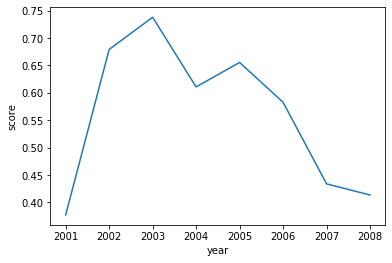

In [33]:
# Make a half-decent time-series -like plot
import seaborn as sns

sns.lineplot(x="year", y= "score", data=su_transcripts);

Hmmm, 2003. Wasn't that the year of the 2nd Gulf War? The invasion of Iraq? 
It began in late March. The address was given in late January.

# Now a section on Sentiment Analysis 

In [34]:
pip install afinn

Note: you may need to restart the kernel to use updated packages.


In [35]:
# initialize afinn sentiment analyzer
from afinn import Afinn
af = Afinn()

# compute sentiment scores (polarity) and labels
sentiment_scores = [af.score(article) for article in su_transcripts['text']]
sentiment_category = ['positive' if score > 0 
                          else 'negative' if score < 0 
                              else 'neutral' 
                                  for score in sentiment_scores]
 
# sentiment statistics per year
df = pd.DataFrame([list(su_transcripts['year']), sentiment_scores, sentiment_category]).T
df.columns = ['year', 'sentiment_score', 'sentiment_category']
df['sentiment_score'] = df.sentiment_score.astype('float')
df.groupby(by=['year']).describe()

sentiment_score                                              
               count   mean std    min    25%    50%    75%    max
year                                                              
2001             1.0  368.0 NaN  368.0  368.0  368.0  368.0  368.0
2002             1.0  112.0 NaN  112.0  112.0  112.0  112.0  112.0
2003             1.0  -16.0 NaN  -16.0  -16.0  -16.0  -16.0  -16.0
2004             1.0  174.0 NaN  174.0  174.0  174.0  174.0  174.0
2005             1.0  293.0 NaN  293.0  293.0  293.0  293.0  293.0
2006             1.0  256.0 NaN  256.0  256.0  256.0  256.0  256.0
2007             1.0  315.0 NaN  315.0  315.0  315.0  315.0  315.0
2008             1.0  488.0 NaN  488.0  488.0  488.0  488.0  488.0

In [36]:
# Interpret the results

# help(Afinn.score)

# What we see is that 2003 stands far apart from other years with regards
#  to the presence of negative language.

/Users/Person/anaconda3/envs/NLP/lib/python3.7/site-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


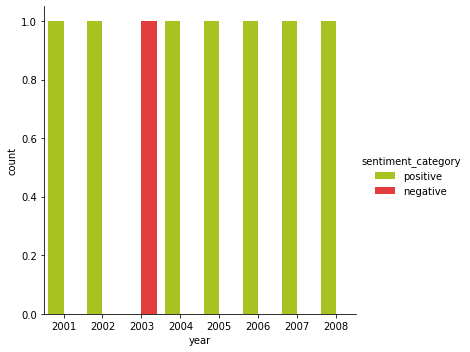

In [37]:
fc = sns.factorplot(x="year", hue="sentiment_category", 
                    data=df, kind="count", 
                    palette={"negative": "#FE2020", 
                             "positive": "#BADD07", 
                             "neutral": "#68BFF5"})

In [38]:
pip install TextBlob

Note: you may need to restart the kernel to use updated packages.


In [39]:
su_transcripts2['text']

0    Mr. Speaker, Mr. Vice President, Members of Co...
1    Thank you very much. Mr. Speaker, Vice Preside...
2    Mr. Speaker, Vice President Cheney, members of...
3    Mr. Speaker, Vice President Cheney, Members of...
4    Mr. Speaker, Vice President Cheney, members of...
5    Today our Nation lost a beloved, graceful, cou...
6    Thank you very much. And tonight, I have a hig...
7    Seven years have passed since I first stood be...
Name: text, dtype: object

In [87]:
su_transcripts2.head()

,text,year
0,"Mr. Speaker, Mr. Vice President, Members of Co...",2001
1,"Thank you very much. Mr. Speaker, Vice Preside...",2002
2,"Mr. Speaker, Vice President Cheney, members of...",2003
3,"Mr. Speaker, Vice President Cheney, Members of...",2004
4,"Mr. Speaker, Vice President Cheney, members of...",2005


In [63]:
su_transcripts2['text'].value_counts

<bound method IndexOpsMixin.value_counts of 0    Mr. Speaker, Mr. Vice President, Members of Co...
1    Thank you very much. Mr. Speaker, Vice Preside...
2    Mr. Speaker, Vice President Cheney, members of...
3    Mr. Speaker, Vice President Cheney, Members of...
4    Mr. Speaker, Vice President Cheney, members of...
5    Today our Nation lost a beloved, graceful, cou...
6    Thank you very much. And tonight, I have a hig...
7    Seven years have passed since I first stood be...
Name: text, dtype: object>

In [88]:
comments.head()

,text,tag
0,&gt;<i>which leads me to say why are you using...,coldtea
1,&#62; If the application becomes successful yo...,eru
2,Borland WebBuilder.,jacquesm
3,Thanks I will look into Pamela Smith&#x27;s wo...,anigbrowl
4,The article mentions infants who are at greate...,DanBC


In [72]:
#comments = comments.dropna()
comments.isna.sum()

AttributeError: 'function' object has no attribute 'isna'

In [57]:
# Now, using TextBlob

from textblob import TextBlob

# compute sentiment scores (polarity) and labels
sentiment_scores_tb = [round(TextBlob(article).sentiment.polarity, 3) for article in comments['text']]
sentiment_category_tb = ['positive' if score > 0 
                             else 'negative' if score < 0 
                                 else 'neutral' 
                                     for score in sentiment_scores_tb]

# sentiment statistics per category
df = pd.DataFrame([list(su_transcripts['year']), sentiment_scores_tb, sentiment_category_tb]).T
df.columns = ['year', 'sentiment_score', 'sentiment_category']
df['sentiment_score'] = df.sentiment_score.astype('float')
df.groupby(by=['year']).describe()

TypeError: The `text` argument passed to `__init__(text)` must be a string, not <class 'float'>

In [41]:
su_transcripts2['year'] = ['2001','2002','2003','2004',
                          '2005','2006','2007','2008']

su_transcripts2

,text,year
0,"Mr. Speaker, Mr. Vice President, Members of Co...",2001
1,"Thank you very much. Mr. Speaker, Vice Preside...",2002
2,"Mr. Speaker, Vice President Cheney, members of...",2003
3,"Mr. Speaker, Vice President Cheney, Members of...",2004
4,"Mr. Speaker, Vice President Cheney, members of...",2005
5,"Today our Nation lost a beloved, graceful, cou...",2006
6,"Thank you very much. And tonight, I have a hig...",2007
7,Seven years have passed since I first stood be...,2008


In [52]:
assert su_transcripts2.text.dtype == comments.text.dtype
print(comments.text.dtype, su_transcripts2.text.dtype)

object object


In [56]:
sentences = []
sentiment_scores = []
sentiment_categories = []
years = []
year = 2001

for i in comments.text:
    list_sentences = nltk.tokenize.sent_tokenize(i)
    sentences.append(list_sentences)
    for i in list_sentences:
        score = round(TextBlob(i).sentiment.polarity, 3)
        sentiment_category = ('positive' if score > 0 
                             else 'negative' if score < 0 
                                 else 'neutral')
        
        years.append(year)
        sentiment_scores.append(score)
        sentiment_categories.append(sentiment_category)
    year = year + 1

TypeError: expected string or bytes-like object

In [54]:
df = pd.DataFrame({'year': years, 
                  'sentiment_score': sentiment_scores,
                  'sentiment_category': sentiment_categories})
df.groupby('year').describe()

sentiment_score                                                     
               count      mean       std    min  25%    50%      75%  max
year                                                                     
2001           273.0  0.129802  0.262625 -1.000  0.0  0.000  0.25800  1.0
2002           215.0  0.133735  0.296818 -1.000  0.0  0.045  0.28400  1.0
2003           286.0  0.104874  0.239806 -1.000  0.0  0.000  0.24150  0.8
2004           280.0  0.115004  0.271143 -1.000  0.0  0.000  0.27775  0.8
2005           235.0  0.129945  0.286521 -1.000  0.0  0.050  0.28800  1.0
2006           266.0  0.105910  0.277338 -1.000  0.0  0.000  0.25000  1.0
2007           348.0  0.110641  0.247463 -1.000  0.0  0.000  0.24425  1.0
2008           382.0  0.084071  0.232667 -0.793  0.0  0.000  0.13600  1.0

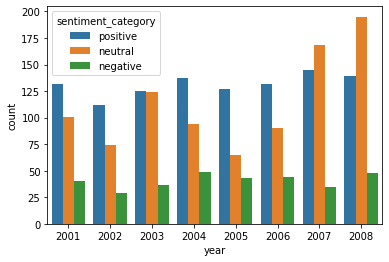

In [55]:
import seaborn 
plot1 = seaborn.countplot(x = 'year', hue = 'sentiment_category', data = df)

In [73]:
df = pd.read_csv('./hacker_news_sample.csv')
top20 = pd.DataFrame(df.by.value_counts()[:20])
top20 = top20.reset_index()
top20 = top20.rename(columns = {'index': 'by', 'by':'total_comments'})
top20_list = top20.by
df_top = df[df['by'].isin(top20_list)]

# Check output
sum(df_top.by.value_counts())

comments = pd.DataFrame({'text': df_top.text, 'tag': df_top.by}).reset_index()
comments = comments.drop('index', axis = 1)
comments.head()

,text,tag
0,&gt;<i>which leads me to say why are you using...,coldtea
1,&#62; If the application becomes successful yo...,eru
2,Borland WebBuilder.,jacquesm
3,Thanks I will look into Pamela Smith&#x27;s wo...,anigbrowl
4,The article mentions infants who are at greate...,DanBC


In [81]:
import pandas as pd
import numpy as np

In [82]:
comments2 = comments.copy

In [86]:
comments2 = comments2.dropna(inplace=True)

AttributeError: 'function' object has no attribute 'dropna'

In [84]:
comments2.isna.sum()

AttributeError: 'function' object has no attribute 'isna'